In [1]:
from six.moves import cPickle as pickle

import sys
# reload(sys)
# sys.setdefaultencoding('utf-8')

import os as os
import fnmatch
import argparse
import pathlib
import time
import itertools

import numpy as np
if "DISPLAY" not in os.environ:
    mpl.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import scipy.io as sio
import glob 

from scipy.stats import randint as sp_randint
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold  # k-fold cross validation StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler  # data normalization
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier  # random forest model
from sklearn.pipeline import Pipeline # model pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import make_scorer


%reload_ext autoreload

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rc('text', usetex=True)
plt.rc('font', family='times')

plt.rcParams.update({'font.size': 22})
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%reload_ext autoreload
%autoreload 2



In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:

knownNames = glob.glob("../dataset/Dados_SONAR/[A-CH]*.mat")

unknownNames = glob.glob("../dataset/Dados_SONAR/[DEFG]*.mat")

X = [sio.loadmat(x)['ent_norm'] for x in knownNames]
Y = [(x.split('/')[-1][0]) for x in knownNames]


X2 = [sio.loadmat(x)['ent_norm'] for x in unknownNames]
# print(X)

minLengthVector = [np.shape(x)[0] for x in X]
minLengthKnown = int(np.min(minLengthVector))

minLengthVector = [np.shape(x)[0] for x in X2]
minLengthUnknown = int(np.min(minLengthVector))

minLength = np.minimum(minLengthKnown, minLengthUnknown)

le = LabelEncoder()
target = le.fit_transform(Y)

print(target)



# minLength = np.zeros(len(names))

# for i in range(len(names)):
#     x = sio.loadmat(str(names[i]))
#     y = x["ent_norm"]
#     minLength[i] = np.shape(y)[0]
# print(np.min(minLength))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 1 2
 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1
 2 2 2 2 2 2 2 2 2 2 2]


In [4]:
xMatrix = np.stack([x[:minLengthKnown,:].reshape(-1) for x in X])
# xMatrix2 = np.stack([x[:minLength,:].reshape(-1) for x in X2])


print(xMatrix.shape)

print(target.shape)
# xMatrix = np.stack([x.reshape(-1) for x in X])


X_train, X_test, y_train, y_test = train_test_split(xMatrix, target, test_size=0.3, random_state=42)

# pca = PCA(10)
# X_train = pca.fit_transform(X_train)
# X_test = pca.fit_transform(X_test)

model = Pipeline([('pca', PCA()), ('rf', RandomForestClassifier(random_state=42, class_weight='balanced'))])
# model = Pipeline([('pca', PCA()), ('svm', svm.LinearSVC())])


(122, 31749)
(122,)


In [5]:
fold = StratifiedKFold(5)


In [6]:
# parameters = {'pca__n_components': [10, 20, 30], 'rf__n_estimators': [10, 50, 100], 'rf__n_jobs': [-1],
#               'rf__min_samples_leaf': [1, 10, 20, 30], 'rf__criterion': ['gini'], 'rf__max_depth': [3, 6, 9 , None]}
metric = metrics.make_scorer(metrics.accuracy_score)
parameters = {'pca__n_components': sp_randint(10, 200), 'rf__n_estimators': sp_randint(10, 100), 'rf__n_jobs': [-1],
              'rf__min_samples_leaf': sp_randint(1, 100), 'rf__criterion': ['gini']}

# parameters = {'pca__n_components': sp_randint(10, 200)}

gridsearchcv = RandomizedSearchCV(model, parameters, scoring=metric, cv=fold, n_iter=20)

# gridsearchcv = GridSearchCV(model, parameters, n_jobs=3, cv=fold, scoring='f1score')
gridsearchcv.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
          error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_node...stimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'pca__n_components': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd370ee5290>, 'rf__criterion': ['gini'], 'rf__n_jobs': [-1], 'rf__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd3422ab050>, 'rf__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd3422ab090>},
          pre

In [7]:
gridsearchcv.grid_scores_

/home/felipe/miniconda2/envs/siemens2.7/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.23529, std: 0.07983, params: {'pca__n_components': 79, 'rf__n_jobs': -1, 'rf__criterion': 'gini', 'rf__n_estimators': 43, 'rf__min_samples_leaf': 45},
 mean: 0.21176, std: 0.08088, params: {'pca__n_components': 136, 'rf__n_jobs': -1, 'rf__criterion': 'gini', 'rf__n_estimators': 58, 'rf__min_samples_leaf': 87},
 mean: 0.22353, std: 0.03579, params: {'pca__n_components': 137, 'rf__n_jobs': -1, 'rf__criterion': 'gini', 'rf__n_estimators': 19, 'rf__min_samples_leaf': 55},
 mean: 0.69412, std: 0.02848, params: {'pca__n_components': 13, 'rf__n_jobs': -1, 'rf__criterion': 'gini', 'rf__n_estimators': 43, 'rf__min_samples_leaf': 18},
 mean: 0.75294, std: 0.04216, params: {'pca__n_components': 15, 'rf__n_jobs': -1, 'rf__criterion': 'gini', 'rf__n_estimators': 89, 'rf__min_samples_leaf': 18},
 mean: 0.21176, std: 0.08088, params: {'pca__n_components': 141, 'rf__n_jobs': -1, 'rf__criterion': 'gini', 'rf__n_estimators': 45, 'rf__min_samples_leaf': 88},
 mean: 0.28235, std: 0.07913, params:

{'pca__n_components': 15, 'rf__n_jobs': -1, 'rf__criterion': 'gini', 'rf__n_estimators': 89, 'rf__min_samples_leaf': 18}
0.783783783784
Confusion matrix, without normalization
[[6 0 1 0]
 [0 9 0 0]
 [2 2 7 1]
 [0 2 0 7]]


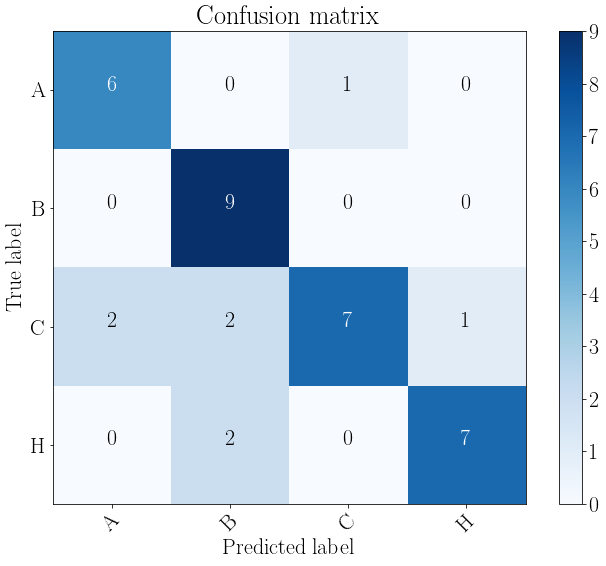

In [8]:
best_n_components = gridsearchcv.best_params_['pca__n_components']

# 
print(gridsearchcv.best_params_)
# metrics.accuracy_score(y_test, gridsearchcv.best_estimator_.predict(X_test))
zip(gridsearchcv.best_estimator_.predict(X_test), np.array(y_test))

print(metrics.accuracy_score(y_test, gridsearchcv.best_estimator_.predict(X_test)))

confusionMatrix = metrics.confusion_matrix(y_test, gridsearchcv.best_estimator_.predict(X_test))

plt.figure()
plot_confusion_matrix(confusionMatrix,classes=['A', 'B', 'C', 'H'])
# resultsTest = gridsearchcv.best_estimator_.predict_proba(X_test)
# print(np.max(resultsTest,axis=1))


In [9]:
# results = gridsearchcv.best_estimator_.predict_proba(xMatrix2)

# print(np.max(results,axis=1))